<a href="https://colab.research.google.com/github/meltyyyyy/kaggle-amex/blob/main/Notebooks/NN/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
class Config:
    name = "NN/Transformer"

    n_splits = 5
    seed = 2022
    target = "target"

    # Colab Env
    upload_from_colab = True
    api_path = "/content/drive/MyDrive/workspace/kaggle.json"
    drive_path = "/content/drive/MyDrive/workspace/kaggle-amex"
    
    # Kaggle Env
    kaggle_dataset_path = None
    
    # Reka Env
    dir_path = '/home/abe/kaggle/kaggle-amex'

In [16]:
import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys
import gc
import multiprocessing
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
import seaborn as sns

from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

In [17]:
COLAB = "google.colab" in sys.modules
if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    # import library
    # ! pip install lightgbm==3.3.1
    # ! pip install --quiet iterative-stratification
    # ! pip install --quiet tensorflow-addons

    # use kaggle api (need kaggle token)
    f = open(Config.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = Config.drive_path
    EXP = (Config.name if Config.name is not None 
           else get("http://172.28.0.2:9000/api/sessions").json()[0]["name"][:-6])
    NOTEBOOKS = os.path.join(DRIVE, 'Notebooks')
    INPUT = os.path.join(DRIVE, "Input")
    OUTPUT = os.path.join(DRIVE, "Output")
    SUBMISSION = os.path.join(DRIVE, "Submission")
    OUTPUT_EXP = os.path.join(OUTPUT, EXP) 
    EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS]:
        os.makedirs(d, exist_ok=True)

This environment is Google Colab


In [22]:
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)

if device_name != b'Tesla T4':
  raise Exception("""
    Unfortunately this instance does not have a T4 GPU.
    
    Please make sure you've configured Colab to request a GPU instance type.
    
    Sometimes Colab allocates a Tesla K80 instead of a T4. Resetting the instance.

    If you get a K80 GPU, try Runtime -> Reset all runtimes...
  """)
else:
  print('Woo! You got the right kind of GPU!')

ModuleNotFoundError: ignored

In [18]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh s

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 300 (delta 74), reused 99 (delta 55), pack-reused 171
Receiving objects: 100% (300/300), 87.58 KiB | 5.15 MiB/s, done.
Resolving deltas: 100% (136/136), done.
PLEASE READ FOR 21.06
********************************************************************************************************
Another release, another script change.  We had to revise the script, which now:
1. Does a more comprehensive install
2. Includes BlazingSQL
3. is far easier for everyone to understand and maintain

The script will require you to add these 5 cells to your notebook.  We have also created a new startup template: 
https://colab.research.google.com/drive/1TAAi_szMfWqRfHVfjGSqnGVLr_ztzUM9?usp=sharing

CHANGES T
CELL 1:
    # This get the RAPIDS-Colab install files and test check your GPU.  Run cells 1 and 2 only.
    # Please

In [19]:
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
import cupy, cudf


PATH_TO_DATA = '../input/amex-data-for-transformers-and-rnns/data/'

# IF YOU WISH TO INFER A MODEL YOU TRAINED OFFLINE
# THEN SET TO FALSE AND PROVIDE KAGGLE DATASET URL
TRAIN_MODEL = True
PATH_TO_MODEL = './model/'

INFER_TEST = True

print('Using TensorFlow version',tf.__version__)

ModuleNotFoundError: ignored

In [8]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(feat_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [6]:
feat_dim = 188
embed_dim = 64  # Embedding size for attention
num_heads = 4  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.3
num_blocks = 2

def build_model():
    
    # INPUT EMBEDDING LAYER
    inp = layers.Input(shape=(13,188))
    embeddings = []
    for k in range(11):
        emb = layers.Embedding(10,4)
        embeddings.append( emb(inp[:,:,k]) )
    x = layers.Concatenate()([inp[:,:,11:]]+embeddings)
    x = layers.Dense(feat_dim)(x)
    
    # TRANSFORMER BLOCKS
    for k in range(num_blocks):
        x_old = x
        transformer_block = TransformerBlock(embed_dim, feat_dim, num_heads, ff_dim, dropout_rate)
        x = transformer_block(x)
        x = 0.9*x + 0.1*x_old # SKIP CONNECTION
    
    # CLASSIFICATION HEAD
    x = layers.Dense(64, activation="relu")(x[:,-1,:])
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs=inp, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(loss=loss, optimizer = opt)
        
    return model

In [11]:
model = build_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 13, 188)]    0           []                               
                                                                                                  
 tf.__operators__.getitem_38 (S  (None, 13)          0           ['input_4[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_39 (S  (None, 13)          0           ['input_4[0][0]']                
 licingOpLambda)                                                                                  
                                                                                            

Learning rate schedule: 0.001 to 0.001 to 1e-06


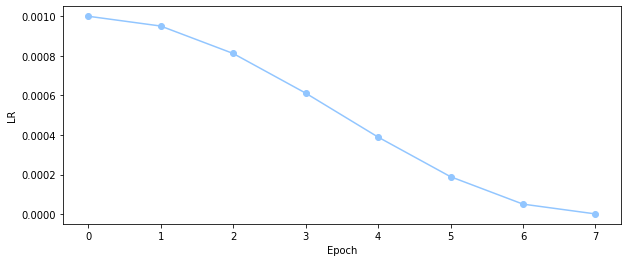

In [12]:
import math
LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [13]:
# COMPETITION METRIC FROM Konstantin Yakovlev
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [ ]:
if TRAIN_MODEL:
    # SAVE TRUE AND OOF
    true = np.array([])
    oof = np.array([])
    VERBOSE = 2 # use 1 for interactive 

    for fold in range(5):

        # INDICES OF TRAIN AND VALID FOLDS
        valid_idx = [2*fold+1, 2*fold+2]
        train_idx = [x for x in [1,2,3,4,5,6,7,8,9,10] if x not in valid_idx]

        print('#'*25)
        print(f'### Fold {fold+1} with valid files', valid_idx)

        # READ TRAIN DATA FROM DISK
        X_train = []; y_train = []
        for k in train_idx:
            X_train.append( np.load(f'{PATH_TO_DATA}data_{k}.npy'))
            y_train.append( pd.read_parquet(f'{PATH_TO_DATA}targets_{k}.pqt') )
        X_train = np.concatenate(X_train,axis=0)
        y_train = pd.concat(y_train).target.values
        print('### Training data shapes', X_train.shape, y_train.shape)

        # READ VALID DATA FROM DISK
        X_valid = []; y_valid = []
        for k in valid_idx:
            X_valid.append( np.load(f'{PATH_TO_DATA}data_{k}.npy'))
            y_valid.append( pd.read_parquet(f'{PATH_TO_DATA}targets_{k}.pqt') )
        X_valid = np.concatenate(X_valid,axis=0)
        y_valid = pd.concat(y_valid).target.values
        print('### Validation data shapes', X_valid.shape, y_valid.shape)
        print('#'*25)

        # BUILD AND TRAIN MODEL
        K.clear_session()
        model = build_model()
        h = model.fit(X_train,y_train, 
                      validation_data = (X_valid,y_valid),
                      batch_size=512, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks = [LR])
        if not os.path.exists(PATH_TO_MODEL): os.makedirs(PATH_TO_MODEL)
        model.save_weights(f'{PATH_TO_MODEL}transformer_fold_{fold+1}.h5')

        # INFER VALID DATA
        print('Inferring validation data...')
        p = model.predict(X_valid, batch_size=512, verbose=VERBOSE).flatten()

        print()
        print(f'Fold {fold+1} CV=', amex_metric_mod(y_valid, p) )
        print()
        true = np.concatenate([true, y_valid])
        oof = np.concatenate([oof, p])
        
        # CLEAN MEMORY
        del model, X_train, y_train, X_valid, y_valid, p
        gc.collect()

    # PRINT OVERALL RESULTS
    print('#'*25)
    print(f'Overall CV =', amex_metric_mod(true, oof) )

In [ ]:
if INFER_TEST:
    # BUILD MODEL
    K.clear_session()
    model = build_model()
    
    # LOAD SAMPLE SUBMISSION
    start = 0; end = 0
    sub = cudf.read_csv('../input/amex-default-prediction/sample_submission.csv')
    
    # REARANGE SUB ROWS TO MATCH 20 TEST FILES
    sub['hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    test_hash_index = cupy.load(f'{PATH_TO_DATA}test_hashes_data.npy')
    sub = sub.set_index('hash').loc[test_hash_index].reset_index(drop=True)
    
    for k in range(20):
        print(f'Inferring Test_File_{k+1}')
        X_test = np.load(f'{PATH_TO_DATA}test_data_{k+1}.npy')
        end = start + X_test.shape[0]

        # INFER 5 FOLD MODELS
        model.load_weights(f'{PATH_TO_MODEL}transformer_fold_1.h5')
        p = model.predict(X_test, batch_size=512, verbose=0).flatten() 
        for j in range(1,5):
            model.load_weights(f'{PATH_TO_MODEL}transformer_fold_{j+1}.h5')
            p += model.predict(X_test, batch_size=512, verbose=0).flatten()
        p /= 5.0

        sub.loc[start:end-1,'prediction'] = p
        start = end